# LIBRARY

In [1]:
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import date, datetime
from multiprocessing.spawn import import_main_path
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np

from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D




# GET DATA

In [2]:
tickers = ["ANTM.JK","ASII.JK","ICBP.JK","JSMR.JK"]

today = date.today()
# print(today)
start_date = '2010-01-01'
# end_date = '2022-08-02'

panel_data = data.DataReader(tickers,'yahoo',start_date,today)
panel_data.head(5)


Attributes    Adj Close                                               Close  \
Symbols         ANTM.JK      ASII.JK      ICBP.JK      JSMR.JK      ANTM.JK   
Date                                                                          
2010-01-04  1576.277344  2454.148926  1408.558960  1530.937866  1931.946777   
2010-01-05  1576.277344  2468.053711  1437.305054  1547.488525  1931.946777   
2010-01-06  1576.277344  2454.148926  1427.723145  1555.763672  1931.946777   
2010-01-07  1610.544189  2377.674072  1437.305054  1547.488525  1973.945557   
2010-01-08  1610.544189  2391.578369  1446.887207  1539.213135  1973.945557   

Attributes                                      High          ...     Low  \
Symbols    ASII.JK ICBP.JK      JSMR.JK      ANTM.JK ASII.JK  ... ICBP.JK   
Date                                                          ...           
2010-01-04  3530.0  1837.5  1845.677368  1931.946777  3550.0  ...  1762.5   
2010-01-05  3550.0  1875.0  1865.630737  1994.945068  3570.0  ...  1825.0   
2010-01-06  3530.0  1862.5  1875.607300  1994.945068  3580.0  ...  1862.5   
2010-01-07  3420.0  1875.0  1865.630737  1994.945068  3560.0  ...  1862.5   
2010-01-08  3440.0  1887.5  1855.654053  1994.945068  3450.0  ...  1862.5   

Attributes                      Open                                   Volume  \
Symbols         JSMR.JK      ANTM.JK ASII.JK ICBP.JK      JSMR.JK     ANTM.JK   
Date                                                                            
2010-01-04  1805.770874  1931.946777  3530.0  1787.5  1845.677368  39619544.0   
2010-01-05  1845.677368  1931.946777  3550.0  1875.0  1865.630737  62041590.0   
2010-01-06  1855.654053  1931.946777  3530.0  1900.0  1875.607300  30916328.0   
2010-01-07  1845.677368  1973.945557  3420.0  1875.0  1865.630737  30624653.0   
2010-01-08  1845.677368  1973.945557  3440.0  1900.0  1855.654053  15857579.0   

Attributes                                 
Symbols    ASII.JK     ICBP.JK    JSMR.JK  
Date                                       
2010-01-04    40.0  26442000.0  6978806.0  
2010-01-05    40.0  42874000.0  7988164.0  
2010-01-06    40.0  44946000.0  7538113.0  
2010-01-07    40.0  24863000.0  2048787.0  
2010-01-08    40.0  19118000.0  2441705.0  

[5 rows x 24 columns]

In [3]:
data_close = panel_data["Adj Close"]
data_close.head(5).round(2)
list(data_close)
data_close.columns = ['antm', 'asii', 'icbp', 'jsmr']
data_close

,antm,asii,icbp,jsmr
Date,,,,
2010-01-04,1576.277344,2454.148926,1408.558960,1530.937866
2010-01-05,1576.277344,2468.053711,1437.305054,1547.488525
2010-01-06,1576.277344,2454.148926,1427.723145,1555.763672
2010-01-07,1610.544189,2377.674072,1437.305054,1547.488525
2010-01-08,1610.544189,2391.578369,1446.887207,1539.213135
...,...,...,...,...
2022-08-08,2060.000000,6700.000000,8800.000000,3420.000000
2022-08-09,2180.000000,6750.000000,8725.000000,3420.000000
2022-08-10,2120.000000,6850.000000,8725.000000,3450.000000


# Normalize data

In [4]:
from sklearn.preprocessing import MinMaxScaler
def normalize_data(df_data, COLUMN_NAME):
    scaler = MinMaxScaler()
    df_data = pd.DataFrame(df_data)
    df_data = pd.DataFrame(scaler.fit_transform(df_data), columns = [COLUMN_NAME])
    return df_data


In [5]:
df_asii = normalize_data(data_close.asii,'asii')
df_icbp = normalize_data(data_close.icbp, 'icbp')
df_jsmr = normalize_data(data_close.jsmr, 'jsmr')

# SLIDING WINDOW FUNCTION

In [6]:
from numpy import array

def split_sequence(seq, n_steps):
    X,y = list(), list()
    for i in range(len(seq)):
        end_ix = i + n_steps
        if end_ix > len(seq)-1:
            break
        seq_x, seq_y =seq[i:end_ix],seq[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# RESET INDEX FUNCTION

In [7]:
from sklearn.model_selection import train_test_split
def reset_index_data(df_data):
    df_data = df_data.reset_index(drop=True)
    arr_df = df_data.to_numpy()
    flat_df = arr_df.flatten()
    return flat_df

# RESHAPE DATA FUNC

In [8]:
def reshape_data(X,N_FEATURES):
    X = X.reshape(X.shape[0],X.shape[1],N_FEATURES)
    return X

# TRAIN VANILA MODEL FUCTION

In [9]:
def train_lstm(X_train,y_train,config):
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_vanila_lstm = Sequential([
    LSTM(neuron, activation=activation,input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_vanila_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    model_vanila_lstm.summary()
    history_vanila_lstm = model_vanila_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          shuffle = True
    )

    return model_vanila_lstm, history_vanila_lstm

#time 41.8
    

In [10]:
def train_vanila_lstm(X_train,y_train,config):
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_vanila_lstm = Sequential([
    LSTM(neuron, activation=activation,input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_vanila_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_vanila_lstm.summary()
    history_vanila_lstm = model_vanila_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_vanila_lstm, history_vanila_lstm

#time 41.8
    

# MATRICS EVALUTE

In [11]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
def matriks_evaluate(preds,y_test, lb_saham):
    print('Matriks score for '+ lb_saham)
    print("mae score: "+str(mean_absolute_error(preds, y_test)))
    print("r2 score "+str(r2_score(preds, y_test)))
    print("mape score "+str(mean_absolute_percentage_error(preds, y_test)))
    print("rmse score "+str(np.sqrt(mean_squared_error(preds, y_test))))

# ROUNDUP FUNCTION

In [26]:
def pembulatan(data,number):
    print(np.round(data,number))

# Tuning Batch size

## ANTM

In [26]:
#get data and normalize data
df_antm = normalize_data(data_close.antm,'antm')
#reset index
df_antm = reset_index_data(df_antm)
#data to supervised
antm_X, antm_y = split_sequence(df_antm, 2)
#split to train and test
X_train_antm, X_test_antm, y_train_antm, y_test_antm = train_test_split(antm_X, antm_y, test_size=0.33, random_state=42)

X_train_antm = reshape_data(X_train_antm,1)
X_test_antm = reshape_data(X_test_antm,1)


In [27]:
cfg_antm = [8,'relu',2,1,0.1,32,200]
model_antm_bs32,history_antm_model  = train_lstm(X_train_antm,y_train_antm,cfg_antm)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8)                 320       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
53/53 [==============================] - 2s 8ms/step - loss: 0.1471 - mae: 0.1471 - val_loss: 0.1457 - val_mae: 0.1457
Epoch 2/200
53/53 [==============================] - 0s 4ms/step - loss: 0.1390 - mae: 0.1390 - val_loss: 0.1461 - val_mae: 0.1461
Epoch 3/200
53/53 [==============================] - 0s 3ms/step - loss: 0.1393 - mae: 0.1393 - val_loss: 0.1475 - val_mae: 0.1475
Epoch 4/200
53/53 [==============================] - 0s 4ms

In [28]:
cfg_antm = [8,'relu',2,1,0.1,16,200]
model_antm_bs16,history_antm_model  = train_lstm(X_train_antm,y_train_antm,cfg_antm)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 8)                 320       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 2s 6ms/step - loss: 0.0440 - mae: 0.0440 - val_loss: 0.0148 - val_mae: 0.0148
Epoch 2/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.0320 - val_mae: 0.0320
Epoch 3/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0202 - mae: 0.0202 - val_loss: 0.0155 - val_mae: 0.0155
Epoch 4/200
105/105 [==============================] 

In [29]:
cfg_antm = [8,'relu',2,1,0.1,8,200]
model_antm_bs8,history_antm_model  = train_lstm(X_train_antm,y_train_antm,cfg_antm)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 8)                 320       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
209/209 [==============================] - 2s 3ms/step - loss: 0.0369 - mae: 0.0369 - val_loss: 0.0328 - val_mae: 0.0328
Epoch 2/200
209/209 [==============================] - 0s 2ms/step - loss: 0.0234 - mae: 0.0234 - val_loss: 0.0393 - val_mae: 0.0393
Epoch 3/200
209/209 [==============================] - 0s 2ms/step - loss: 0.0201 - mae: 0.0201 - val_loss: 0.0093 - val_mae: 0.0093
Epoch 4/200
209/209 [==============================] 

In [30]:
preds_antm_bs32 = model_antm_bs32.predict(X_test_antm)
matriks_evaluate(preds_antm_bs32,y_test_antm,'antm')

Matriks score for antm
mae score: 0.14910318578612322
r2 score -12916762222769.193
mape score 0.6321739528965653
rmse score 0.21421848154314144


In [75]:
pembulatan(0.14910318578612322)
pembulatan(-12916762222769.193)
pembulatan(0.6321739528965653)
pembulatan(0.21421848154314144)

0.15
-12916762222769.19
0.63
0.21


In [31]:
preds_antm_bs16 = model_antm_bs16.predict(X_test_antm)
matriks_evaluate(preds_antm_bs16,y_test_antm,'antm')

Matriks score for antm
mae score: 0.012999653801640209
r2 score 0.9919025455962707
mape score 0.07505881372311643
rmse score 0.018099920968931704


In [73]:
pembulatan(0.012999653801640209)
pembulatan(0.9919025455962707)
pembulatan(0.07505881372311643)
pembulatan(0.018099920968931704)

0.01
0.99
0.08
0.02


In [32]:
preds_antm_bs8 = model_antm_bs8.predict(X_test_antm)
matriks_evaluate(preds_antm_bs8,y_test_antm,'antm')

Matriks score for antm
mae score: 0.011365720854837554
r2 score 0.9939515647082884
mape score 0.053395620704576
rmse score 0.015886105416762518


In [74]:
pembulatan(0.011365720854837554)
pembulatan(0.9939515647082884)
pembulatan(0.053395620704576)
pembulatan(0.015886105416762518)

0.01
0.99
0.05
0.02


In [85]:
mae_antm_hl_u_lr_ep = {'model_bs32':mean_absolute_error(preds_antm_bs32, y_test_antm),'model_bs16':mean_absolute_error(preds_antm_bs16, y_test_antm),'model_bs8':mean_absolute_error(preds_antm_bs8, y_test_antm)}

mape_antm_hl_u_lr_ep = {'model_bs32':mean_absolute_percentage_error(preds_antm_bs32, y_test_antm),'model_bs16':mean_absolute_percentage_error(preds_antm_bs16, y_test_antm),'model_bs8':mean_absolute_percentage_error(preds_antm_bs8, y_test_antm)}

rmse_antm_hl_u_lr_ep = {'model_bs32':np.sqrt(mean_squared_error(preds_antm_bs32, y_test_antm)),'model_bs16':np.sqrt(mean_squared_error(preds_antm_bs16, y_test_antm)),'model_bs8':np.sqrt(mean_squared_error(preds_antm_bs8, y_test_antm))}

r2_antm_hl_u_lr_ep = {'model_bs32':r2_score(preds_antm_bs32, y_test_antm),'model_bs16':r2_score(preds_antm_bs16, y_test_antm),'model_bs8':r2_score(preds_antm_bs8, y_test_antm)} 

In [86]:
print("sorted mae")
mae_antm_hl_u_lr_ep_sorted = dict(sorted(mae_antm_hl_u_lr_ep.items(),key=lambda item: item[1]))
print(mae_antm_hl_u_lr_ep_sorted)
print("sorted rmse")
rmse_antm_hl_u_lr_ep_sorted = dict(sorted(rmse_antm_hl_u_lr_ep.items(),key=lambda item: item[1]))
print(rmse_antm_hl_u_lr_ep_sorted)
print("sorted mape")
mape_antm_hl_u_lr_ep_sorted = dict(sorted(mape_antm_hl_u_lr_ep.items(),key=lambda item: item[1]))
print(mape_antm_hl_u_lr_ep_sorted)
print("sorted r2")
r2_antm_hl_u_lr_ep_sorted = dict(sorted(r2_antm_hl_u_lr_ep.items(),key=lambda item: item[1] ,reverse=True))
print(r2_antm_hl_u_lr_ep_sorted)

sorted mae
{'model_bs8': 0.011365720854837554, 'model_bs16': 0.012999653801640209, 'model_bs32': 0.14910318578612322}
sorted rmse
{'model_bs8': 0.015886105416762518, 'model_bs16': 0.018099920968931704, 'model_bs32': 0.21421848154314144}
sorted mape
{'model_bs8': 0.053395620704576, 'model_bs16': 0.07505881372311643, 'model_bs32': 0.6321739528965653}
sorted r2
{'model_bs8': 0.9939515647082884, 'model_bs16': 0.9919025455962707, 'model_bs32': -12916762222769.193}


## ASII

In [34]:
#get data and normalize data
df_asii = normalize_data(data_close.asii,'asii')
#reset index
df_asii = reset_index_data(df_asii)
#data to supervised
asii_X, asii_y = split_sequence(df_asii, 3)
#split to train and test
X_train_asii, X_test_asii, y_train_asii, y_test_asii = train_test_split(asii_X, asii_y, test_size=0.33, random_state=42)

X_train_asii = reshape_data(X_train_asii,1)
X_test_asii = reshape_data(X_test_asii,1)


In [35]:
cfg_asii = [32,'relu',3,1,0.01,32,150]
model_asii_bs32,history_asii_model,  = train_lstm(X_train_asii,y_train_asii,cfg_asii)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 32)                4352      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
53/53 [==============================] - 2s 8ms/step - loss: 0.0855 - mae: 0.0855 - val_loss: 0.0189 - val_mae: 0.0189
Epoch 2/150
53/53 [==============================] - 0s 4ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0216 - val_mae: 0.0216
Epoch 3/150
53/53 [==============================] - 0s 4ms/step - loss: 0.0215 - mae: 0.0215 - val_loss: 0.0172 - val_mae: 0.0172
Epoch 4/150
53/53 [==============================] - 0s

In [36]:
cfg_asii = [32,'relu',3,1,0.01,16,150]
model_asii_bs16,history_asii_model,  = train_lstm(X_train_asii,y_train_asii,cfg_asii)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 32)                4352      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
105/105 [==============================] - 2s 5ms/step - loss: 0.1156 - mae: 0.1156 - val_loss: 0.0235 - val_mae: 0.0235
Epoch 2/150
105/105 [==============================] - 0s 3ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0192 - val_mae: 0.0192
Epoch 3/150
105/105 [==============================] - 0s 3ms/step - loss: 0.0215 - mae: 0.0215 - val_loss: 0.0191 - val_mae: 0.0191
Epoch 4/150
105/105 [============================

In [37]:
cfg_asii = [32,'relu',3,1,0.01,8,150]
model_asii_bs8,history_asii_model,  = train_lstm(X_train_asii,y_train_asii,cfg_asii)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 32)                4352      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
209/209 [==============================] - 2s 4ms/step - loss: 0.0668 - mae: 0.0668 - val_loss: 0.0192 - val_mae: 0.0192
Epoch 2/150
209/209 [==============================] - 1s 3ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0177 - val_mae: 0.0177
Epoch 3/150
209/209 [==============================] - 1s 3ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0432 - val_mae: 0.0432
Epoch 4/150
209/209 [============================

In [38]:
preds_asii_bs32 = model_asii_bs32.predict(X_test_asii)
matriks_evaluate(preds_asii_bs32,y_test_asii,'asii')

Matriks score for asii
mae score: 0.016920856064242262
r2 score 0.9874077270736897
mape score 0.03633563979389126
rmse score 0.022011401288948202


In [76]:
pembulatan(0.016920856064242262)
pembulatan(0.9874077270736897)
pembulatan(0.03633563979389126)
pembulatan(0.022011401288948202)

0.02
0.99
0.04
0.02


In [39]:
preds_asii_bs16 = model_asii_bs16.predict(X_test_asii)
matriks_evaluate(preds_asii_bs16,y_test_asii,'asii')

Matriks score for asii
mae score: 0.017254665063887373
r2 score 0.9879353116214824
mape score 0.04013173821403081
rmse score 0.021790129419086132


In [83]:
pembulatan(0.017254665063887373)
pembulatan(0.9879353116214824)
pembulatan(0.04013173821403081)
pembulatan(0.021790129419086132)

0.02
0.99
0.04
0.02


In [40]:
preds_asii_bs8 = model_asii_bs8.predict(X_test_asii)
matriks_evaluate(preds_asii_bs8,y_test_asii,'asii')

Matriks score for asii
mae score: 0.015346604139969425
r2 score 0.9900479608200057
mape score 0.033018683195921786
rmse score 0.02020180579718549


In [84]:
pembulatan(0.015346604139969425)
pembulatan(0.9900479608200057)
pembulatan(0.033018683195921786)
pembulatan(0.02020180579718549)

0.02
0.99
0.03
0.02


In [87]:
mae_asii_hl_u_lr_ep = {'model_bs32':mean_absolute_error(preds_asii_bs32, y_test_asii),'model_bs16':mean_absolute_error(preds_asii_bs16, y_test_asii),'model_bs8':mean_absolute_error(preds_asii_bs8, y_test_asii)}

mape_asii_hl_u_lr_ep = {'model_bs32':mean_absolute_percentage_error(preds_asii_bs32, y_test_asii),'model_bs16':mean_absolute_percentage_error(preds_asii_bs16, y_test_asii),'model_bs8':mean_absolute_percentage_error(preds_asii_bs8, y_test_asii)}

rmse_asii_hl_u_lr_ep = {'model_bs32':np.sqrt(mean_squared_error(preds_asii_bs32, y_test_asii)),'model_bs16':np.sqrt(mean_squared_error(preds_asii_bs16, y_test_asii)),'model_bs8':np.sqrt(mean_squared_error(preds_asii_bs8, y_test_asii))}

r2_asii_hl_u_lr_ep = {'model_bs32':r2_score(preds_asii_bs32, y_test_asii),'model_bs16':r2_score(preds_asii_bs16, y_test_asii),'model_bs8':r2_score(preds_asii_bs8, y_test_asii)} 

In [88]:
print("sorted mae")
mae_asii_hl_u_lr_ep_sorted = dict(sorted(mae_asii_hl_u_lr_ep.items(),key=lambda item: item[1]))
print(mae_asii_hl_u_lr_ep_sorted)
print("sorted rmse")
rmse_asii_hl_u_lr_ep_sorted = dict(sorted(rmse_asii_hl_u_lr_ep.items(),key=lambda item: item[1]))
print(rmse_asii_hl_u_lr_ep_sorted)
print("sorted mape")
mape_asii_hl_u_lr_ep_sorted = dict(sorted(mape_asii_hl_u_lr_ep.items(),key=lambda item: item[1]))
print(mape_asii_hl_u_lr_ep_sorted)
print("sorted r2")
r2_asii_hl_u_lr_ep_sorted = dict(sorted(r2_asii_hl_u_lr_ep.items(),key=lambda item: item[1] ,reverse=True))
print(r2_asii_hl_u_lr_ep_sorted)

sorted mae
{'model_bs8': 0.015346604139969425, 'model_bs32': 0.016920856064242262, 'model_bs16': 0.017254665063887373}
sorted rmse
{'model_bs8': 0.02020180579718549, 'model_bs16': 0.021790129419086132, 'model_bs32': 0.022011401288948202}
sorted mape
{'model_bs8': 0.033018683195921786, 'model_bs32': 0.03633563979389126, 'model_bs16': 0.04013173821403081}
sorted r2
{'model_bs8': 0.9900479608200057, 'model_bs16': 0.9879353116214824, 'model_bs32': 0.9874077270736897}


## ICBP

In [42]:
#get data and normalize data
df_icbp = normalize_data(data_close.icbp,'icbp')
#reset index
df_icbp = reset_index_data(df_icbp)
#data to supervised
icbp_X, icbp_y = split_sequence(df_icbp, 1)
#split to train and test
X_train_icbp, X_test_icbp, y_train_icbp, y_test_icbp = train_test_split(icbp_X, icbp_y, test_size=0.33, random_state=42)

X_train_icbp = reshape_data(X_train_icbp,1)
X_test_icbp = reshape_data(X_test_icbp,1)


In [43]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_icbp = [8,'relu',1,1,0.01,32,200]
model_icbp_bs32,history_icbp_model,  = train_lstm(X_train_icbp,y_train_icbp,cfg_icbp)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 8)                 320       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
53/53 [==============================] - 1s 8ms/step - loss: 0.2057 - mae: 0.2057 - val_loss: 0.0882 - val_mae: 0.0882
Epoch 2/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0466 - mae: 0.0466 - val_loss: 0.0233 - val_mae: 0.0233
Epoch 3/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0212 - val_mae: 0.0212
Epoch 4/200
53/53 [==============================] - 0s 3ms

In [44]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_icbp = [8,'relu',1,1,0.01,16,200]
model_icbp_bs16,history_icbp_model,  = train_lstm(X_train_icbp,y_train_icbp,cfg_icbp)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 8)                 320       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 2s 4ms/step - loss: 0.1408 - mae: 0.1408 - val_loss: 0.0287 - val_mae: 0.0287
Epoch 2/200
105/105 [==============================] - 0s 2ms/step - loss: 0.0232 - mae: 0.0232 - val_loss: 0.0176 - val_mae: 0.0176
Epoch 3/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0180 - mae: 0.0180 - val_loss: 0.0149 - val_mae: 0.0149
Epoch 4/200
105/105 [==============================] 

In [45]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_icbp = [8,'relu',1,1,0.01,8,200]
model_icbp_bs8,history_icbp_model,  = train_lstm(X_train_icbp,y_train_icbp,cfg_icbp)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 8)                 320       
                                                                 
 dense_10 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
210/210 [==============================] - 2s 4ms/step - loss: 0.0802 - mae: 0.0802 - val_loss: 0.0170 - val_mae: 0.0170
Epoch 2/200
210/210 [==============================] - 1s 2ms/step - loss: 0.0170 - mae: 0.0170 - val_loss: 0.0102 - val_mae: 0.0102
Epoch 3/200
210/210 [==============================] - 1s 2ms/step - loss: 0.0117 - mae: 0.0117 - val_loss: 0.0098 - val_mae: 0.0098
Epoch 4/200
210/210 [==============================]

In [46]:
preds_icbp_bs32 = model_icbp_bs32.predict(X_test_icbp)
matriks_evaluate(preds_icbp_bs32,y_test_icbp,'icbp')

Matriks score for icbp
mae score: 0.007353329179454687
r2 score 0.9981393854996866
mape score 0.02843190299760299
rmse score 0.01201080759215415


In [79]:
pembulatan(0.007353329179454687)
pembulatan(0.9981393854996866)
pembulatan(0.02843190299760299)
pembulatan(0.01201080759215415)

0.01
1.0
0.03
0.01


In [47]:
preds_icbp_bs16 = model_icbp_bs16.predict(X_test_icbp)
matriks_evaluate(preds_icbp_bs16,y_test_icbp,'icbp')

Matriks score for icbp
mae score: 0.007274663427842254
r2 score 0.9981533501318129
mape score 0.0277478888285619
rmse score 0.011995981801348952


In [78]:
pembulatan(0.007274663427842254)
pembulatan(0.9981533501318129)
pembulatan(0.0277478888285619)
pembulatan(0.011995981801348952)

0.01
1.0
0.03
0.01


In [48]:
preds_icbp_bs8 = model_icbp_bs8.predict(X_test_icbp)
matriks_evaluate(preds_icbp_bs8,y_test_icbp,'icbp')

Matriks score for icbp
mae score: 0.014329047331934453
r2 score 0.9953377625240442
mape score 0.06350116606387053
rmse score 0.018692824157166034


In [77]:
pembulatan(0.014329047331934453)
pembulatan(0.9953377625240442)
pembulatan(0.06350116606387053)
pembulatan(0.018692824157166034)

0.01
1.0
0.06
0.02


In [89]:
mae_icbp_hl_u_lr_ep = {'model_bs32':mean_absolute_error(preds_icbp_bs32, y_test_icbp),'model_bs16':mean_absolute_error(preds_icbp_bs16, y_test_icbp),'model_bs8':mean_absolute_error(preds_icbp_bs8, y_test_icbp)}

mape_icbp_hl_u_lr_ep = {'model_bs32':mean_absolute_percentage_error(preds_icbp_bs32, y_test_icbp),'model_bs16':mean_absolute_percentage_error(preds_icbp_bs16, y_test_icbp),'model_bs8':mean_absolute_percentage_error(preds_icbp_bs8, y_test_icbp)}

rmse_icbp_hl_u_lr_ep = {'model_bs32':np.sqrt(mean_squared_error(preds_icbp_bs32, y_test_icbp)),'model_bs16':np.sqrt(mean_squared_error(preds_icbp_bs16, y_test_icbp)),'model_bs8':np.sqrt(mean_squared_error(preds_icbp_bs8, y_test_icbp))}

r2_icbp_hl_u_lr_ep = {'model_bs32':r2_score(preds_icbp_bs32, y_test_icbp),'model_bs16':r2_score(preds_icbp_bs16, y_test_icbp),'model_bs8':r2_score(preds_icbp_bs8, y_test_icbp)} 

In [90]:
print("sorted mae")
mae_icbp_hl_u_lr_ep_sorted = dict(sorted(mae_icbp_hl_u_lr_ep.items(),key=lambda item: item[1]))
print(mae_icbp_hl_u_lr_ep_sorted)
print("sorted rmse")
rmse_icbp_hl_u_lr_ep_sorted = dict(sorted(rmse_icbp_hl_u_lr_ep.items(),key=lambda item: item[1]))
print(rmse_icbp_hl_u_lr_ep_sorted)
print("sorted mape")
mape_icbp_hl_u_lr_ep_sorted = dict(sorted(mape_icbp_hl_u_lr_ep.items(),key=lambda item: item[1]))
print(mape_icbp_hl_u_lr_ep_sorted)
print("sorted r2")
r2_icbp_hl_u_lr_ep_sorted = dict(sorted(r2_icbp_hl_u_lr_ep.items(),key=lambda item: item[1] ,reverse=True))
print(r2_icbp_hl_u_lr_ep_sorted)

sorted mae
{'model_bs16': 0.007274663427842254, 'model_bs32': 0.007353329179454687, 'model_bs8': 0.014329047331934453}
sorted rmse
{'model_bs16': 0.011995981801348952, 'model_bs32': 0.01201080759215415, 'model_bs8': 0.018692824157166034}
sorted mape
{'model_bs16': 0.0277478888285619, 'model_bs32': 0.02843190299760299, 'model_bs8': 0.06350116606387053}
sorted r2
{'model_bs16': 0.9981533501318129, 'model_bs32': 0.9981393854996866, 'model_bs8': 0.9953377625240442}


## JSMR

In [50]:
#get data and normalize data
df_jsmr = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr = reset_index_data(df_jsmr)
#data to supervised
jsmr_X, jsmr_y = split_sequence(df_jsmr, 1)
#split to train and test
X_train_jsmr, X_test_jsmr, y_train_jsmr, y_test_jsmr = train_test_split(jsmr_X, jsmr_y, test_size=0.33, random_state=42)

X_train_jsmr = reshape_data(X_train_jsmr,1)
X_test_jsmr = reshape_data(X_test_jsmr,1)


In [51]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_jsmr = [8,'relu',1,1,0.01,32,200]
model_jsmr_bs32,history_jsmr_model,  = train_lstm(X_train_jsmr,y_train_jsmr,cfg_jsmr)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 8)                 320       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
53/53 [==============================] - 1s 7ms/step - loss: 0.2825 - mae: 0.2825 - val_loss: 0.1119 - val_mae: 0.1119
Epoch 2/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0979 - mae: 0.0979 - val_loss: 0.0712 - val_mae: 0.0712
Epoch 3/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0467 - mae: 0.0467 - val_loss: 0.0204 - val_mae: 0.0204
Epoch 4/200
53/53 [==============================] - 0s 3m

In [52]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_jsmr = [8,'relu',1,1,0.01,16,200]
model_jsmr_bs16,history_jsmr_model,  = train_lstm(X_train_jsmr,y_train_jsmr,cfg_jsmr)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 8)                 320       
                                                                 
 dense_12 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 2s 7ms/step - loss: 0.1600 - mae: 0.1600 - val_loss: 0.0419 - val_mae: 0.0419
Epoch 2/200
105/105 [==============================] - 0s 2ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0178 - val_mae: 0.0178
Epoch 3/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0191 - mae: 0.0191 - val_loss: 0.0165 - val_mae: 0.0165
Epoch 4/200
105/105 [==============================]

In [53]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_jsmr = [8,'relu',1,1,0.01,8,200]
model_jsmr_bs8,history_jsmr_model,  = train_lstm(X_train_jsmr,y_train_jsmr,cfg_jsmr)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 8)                 320       
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
210/210 [==============================] - 2s 3ms/step - loss: 0.0805 - mae: 0.0805 - val_loss: 0.0189 - val_mae: 0.0189
Epoch 2/200
210/210 [==============================] - 1s 2ms/step - loss: 0.0215 - mae: 0.0215 - val_loss: 0.0236 - val_mae: 0.0236
Epoch 3/200
210/210 [==============================] - 1s 2ms/step - loss: 0.0194 - mae: 0.0194 - val_loss: 0.0166 - val_mae: 0.0166
Epoch 4/200
210/210 [==============================]

In [54]:
preds_jsmr_bs32 = model_jsmr_bs32.predict(X_test_jsmr)
matriks_evaluate(preds_jsmr_bs32,y_test_jsmr,'jsmr')

Matriks score for jsmr
mae score: 0.017781660946700365
r2 score 0.9887229545556224
mape score 0.057102426873167404
rmse score 0.02244715803377186


In [82]:
pembulatan(0.017781660946700365)
pembulatan(0.9887229545556224)
pembulatan(0.057102426873167404)
pembulatan(0.02244715803377186)

0.02
0.99
0.06
0.02


In [55]:
preds_jsmr_bs16 = model_jsmr_bs16.predict(X_test_jsmr)
matriks_evaluate(preds_jsmr_bs16,y_test_jsmr,'jsmr')

Matriks score for jsmr
mae score: 0.011454908625903459
r2 score 0.9940081988547483
mape score 0.028470031941793497
rmse score 0.016602562556061077


In [80]:
pembulatan(0.011454908625903459)
pembulatan(0.9940081988547483)
pembulatan(0.028470031941793497)
pembulatan(0.016602562556061077)

0.01
0.99
0.03
0.02


In [56]:
preds_jsmr_bs8 = model_jsmr_bs8.predict(X_test_jsmr)
matriks_evaluate(preds_jsmr_bs8,y_test_jsmr,'jsmr')

Matriks score for jsmr
mae score: 0.011488508080148499
r2 score 0.9939849099075261
mape score 0.029825446451819868
rmse score 0.01656066385999743


In [81]:
pembulatan(0.011488508080148499)
pembulatan(0.9939849099075261)
pembulatan(0.029825446451819868)
pembulatan(0.01656066385999743)

0.01
0.99
0.03
0.02


In [91]:
mae_jsmr_hl_u_lr_ep = {'model_bs32':mean_absolute_error(preds_jsmr_bs32, y_test_jsmr),'model_bs16':mean_absolute_error(preds_jsmr_bs16, y_test_jsmr),'model_bs8':mean_absolute_error(preds_jsmr_bs8, y_test_jsmr)}

mape_jsmr_hl_u_lr_ep = {'model_bs32':mean_absolute_percentage_error(preds_jsmr_bs32, y_test_jsmr),'model_bs16':mean_absolute_percentage_error(preds_jsmr_bs16, y_test_jsmr),'model_bs8':mean_absolute_percentage_error(preds_jsmr_bs8, y_test_jsmr)}

rmse_jsmr_hl_u_lr_ep = {'model_bs32':np.sqrt(mean_squared_error(preds_jsmr_bs32, y_test_jsmr)),'model_bs16':np.sqrt(mean_squared_error(preds_jsmr_bs16, y_test_jsmr)),'model_bs8':np.sqrt(mean_squared_error(preds_jsmr_bs8, y_test_jsmr))}

r2_jsmr_hl_u_lr_ep = {'model_bs32':r2_score(preds_jsmr_bs32, y_test_jsmr),'model_bs16':r2_score(preds_jsmr_bs16, y_test_jsmr),'model_bs8':r2_score(preds_jsmr_bs8, y_test_jsmr)} 

In [92]:
print("sorted mae")
mae_jsmr_hl_u_lr_ep_sorted = dict(sorted(mae_jsmr_hl_u_lr_ep.items(),key=lambda item: item[1]))
print(mae_jsmr_hl_u_lr_ep_sorted)
print("sorted rmse")
rmse_jsmr_hl_u_lr_ep_sorted = dict(sorted(rmse_jsmr_hl_u_lr_ep.items(),key=lambda item: item[1]))
print(rmse_jsmr_hl_u_lr_ep_sorted)
print("sorted mape")
mape_jsmr_hl_u_lr_ep_sorted = dict(sorted(mape_jsmr_hl_u_lr_ep.items(),key=lambda item: item[1]))
print(mape_jsmr_hl_u_lr_ep_sorted)
print("sorted r2")
r2_jsmr_hl_u_lr_ep_sorted = dict(sorted(r2_jsmr_hl_u_lr_ep.items(),key=lambda item: item[1] ,reverse=True))
print(r2_jsmr_hl_u_lr_ep_sorted)

sorted mae
{'model_bs16': 0.011454908625903459, 'model_bs8': 0.011488508080148499, 'model_bs32': 0.017781660946700365}
sorted rmse
{'model_bs8': 0.01656066385999743, 'model_bs16': 0.016602562556061077, 'model_bs32': 0.02244715803377186}
sorted mape
{'model_bs16': 0.028470031941793497, 'model_bs8': 0.029825446451819868, 'model_bs32': 0.057102426873167404}
sorted r2
{'model_bs16': 0.9940081988547483, 'model_bs8': 0.9939849099075261, 'model_bs32': 0.9887229545556224}


## KESIMPULAN BATCH SIZE

Pada tuning batchj size ini terdapat beberapa hasil untuk ANTM 8 ASII 8 ICBP dan JSMR 16

# VANILA LSTM

## ANTM

In [13]:
#get data and normalize data
df_antm = normalize_data(data_close.antm,'antm')
#reset index
df_antm = reset_index_data(df_antm)
#data to supervised
antm_X, antm_y = split_sequence(df_antm, 2)
#split to train and test
X_train_antm, X_test_antm, y_train_antm, y_test_antm = train_test_split(antm_X, antm_y, test_size=0.33, random_state=42)

X_train_antm = reshape_data(X_train_antm,1)
X_test_antm = reshape_data(X_test_antm,1)


In [14]:
cfg_antm = [8,'relu',2,1,0.1,8,200]
model_antm,history_antm_model,  = train_vanila_lstm(X_train_antm,y_train_antm,cfg_antm)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
210/210 [==============================] - 3s 6ms/step - loss: 0.0444 - mae: 0.0444 - val_loss: 0.0378 - val_mae: 0.0378
Epoch 2/200
210/210 [==============================] - 1s 3ms/step - loss: 0.0234 - mae: 0.0234 - val_loss: 0.0323 - val_mae: 0.0323
Epoch 3/200
210/210 [==============================] - 1s 3ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0384 - val_mae: 0.0384
Epoch 4/200
210/210 [==============================] - 

In [15]:
preds_antm = model_antm.predict(X_test_antm)
matriks_evaluate(preds_antm,y_test_antm,'antm')

Matriks score for antm
mae score: 0.007934620954499606
r2 score 0.9957026171046904
mape score 0.04075884954250871
rmse score 0.01301039855428923


In [27]:
# Matriks score for antm
pembulatan(0.007934620954499606,4)
pembulatan(0.9957026171046904,4)
pembulatan(0.04075884954250871,4)
pembulatan(0.01301039855428923,4)

0.0079
0.9957
0.0408
0.013


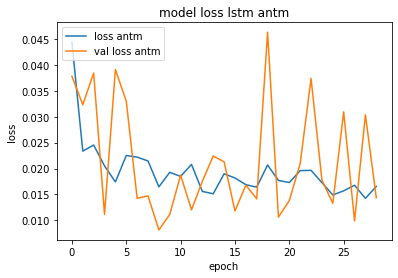

In [36]:
plt.plot(history_antm_model.history['loss'], label='loss antm')
plt.plot(history_antm_model.history['val_loss'], label = 'val loss antm')
plt.title('model loss lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_antm', dpi=3600)

## ASII

In [16]:
#get data and normalize data
df_asii = normalize_data(data_close.asii,'asii')
#reset index
df_asii = reset_index_data(df_asii)
#data to supervised
asii_X, asii_y = split_sequence(df_asii, 3)
#split to train and test
X_train_asii, X_test_asii, y_train_asii, y_test_asii = train_test_split(asii_X, asii_y, test_size=0.33, random_state=42)

X_train_asii = reshape_data(X_train_asii,1)
X_test_asii = reshape_data(X_test_asii,1)


In [17]:
cfg_asii = [32,'relu',3,1,0.01,8,150]
model_asii,history_asii_model,  = train_vanila_lstm(X_train_asii,y_train_asii,cfg_asii)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
209/209 [==============================] - 3s 5ms/step - loss: 0.0473 - mae: 0.0473 - val_loss: 0.0192 - val_mae: 0.0192
Epoch 2/150
209/209 [==============================] - 1s 3ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0211 - val_mae: 0.0211
Epoch 3/150
209/209 [==============================] - 1s 3ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0214 - val_mae: 0.0214
Epoch 4/150
209/209 [============================

In [18]:
preds_asii = model_asii.predict(X_test_asii)
matriks_evaluate(preds_asii,y_test_asii,'asii')

Matriks score for asii
mae score: 0.014477178205400888
r2 score 0.9906708116313951
mape score 0.03233571113583237
rmse score 0.019196850071116774


In [29]:
# Matriks score for asii
pembulatan(0.014477178205400888,4)
pembulatan(0.9906708116313951,4)
pembulatan(0.03233571113583237,4)
pembulatan(0.019196850071116774,4)

0.0145
0.9907
0.0323
0.0192


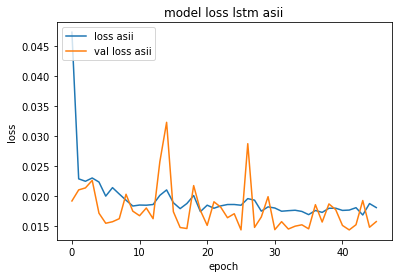

In [35]:
plt.plot(history_asii_model.history['loss'], label='loss asii')
plt.plot(history_asii_model.history['val_loss'], label = 'val loss asii')
plt.title('model loss lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_asii', dpi=3600)

## ICBP


In [19]:
#get data and normalize data
df_icbp = normalize_data(data_close.icbp,'icbp')
#reset index
df_icbp = reset_index_data(df_icbp)
#data to supervised
icbp_X, icbp_y = split_sequence(df_icbp, 1)
#split to train and test
X_train_icbp, X_test_icbp, y_train_icbp, y_test_icbp = train_test_split(icbp_X, icbp_y, test_size=0.33, random_state=42)

X_train_icbp = reshape_data(X_train_icbp,1)
X_test_icbp = reshape_data(X_test_icbp,1)


In [20]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_icbp = [8,'relu',1,1,0.01,16,200]
model_icbp,history_icbp_model,  = train_vanila_lstm(X_train_icbp,y_train_icbp,cfg_icbp)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8)                 320       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 2s 6ms/step - loss: 0.1356 - mae: 0.1356 - val_loss: 0.0230 - val_mae: 0.0230
Epoch 2/200
105/105 [==============================] - 0s 2ms/step - loss: 0.0204 - mae: 0.0204 - val_loss: 0.0211 - val_mae: 0.0211
Epoch 3/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0160 - mae: 0.0160 - val_loss: 0.0109 - val_mae: 0.0109
Epoch 4/200
105/105 [==============================] 

In [21]:
preds_icbp = model_icbp.predict(X_test_icbp)
matriks_evaluate(preds_icbp,y_test_icbp,'icbp')

Matriks score for icbp
mae score: 0.007518278165003873
r2 score 0.9980980760462315
mape score 0.03298193863122954
rmse score 0.01215460388750067


In [30]:
# Matriks score for icbp
pembulatan(0.007518278165003873
,4)
pembulatan(0.9980980760462315,4)
pembulatan(0.03298193863122954,4)
pembulatan(0.01215460388750067,4)

0.0075
0.9981
0.033
0.0122


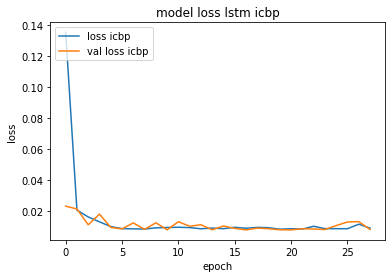

In [37]:
plt.plot(history_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_icbp_model.history['val_loss'], label = 'val loss icbp')
plt.title('model loss lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_icbp', dpi=3600)

## JSMR

In [161]:
#get data and normalize data
df_jsmr = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr = reset_index_data(df_jsmr)
#data to supervised
jsmr_X, jsmr_y = split_sequence(df_jsmr, 1)
#split to train and test
X_train_jsmr, X_test_jsmr, y_train_jsmr, y_test_jsmr = train_test_split(jsmr_X, jsmr_y, test_size=0.33, random_state=42)

X_train_jsmr = reshape_data(X_train_jsmr,1)
X_test_jsmr = reshape_data(X_test_jsmr,1)


In [162]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_jsmr = [8,'relu',1,1,0.01,16,200]
model_jsmr,history_jsmr_model,  = train_vanila_lstm(X_train_jsmr,y_train_jsmr,cfg_jsmr)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 8)                 320       
                                                                 
 dense_26 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 5s 10ms/step - loss: 0.2078 - mae: 0.2078 - val_loss: 0.0971 - val_mae: 0.0971
Epoch 2/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0483 - mae: 0.0483 - val_loss: 0.0192 - val_mae: 0.0192
Epoch 3/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0219 - mae: 0.0219 - val_loss: 0.0186 - val_mae: 0.0186
Epoch 4/200
105/105 [==============================

In [166]:
preds_jsmr = model_jsmr.predict(X_test_jsmr)
matriks_evaluate(preds_jsmr,y_test_jsmr,'jsmr')

Matriks score for jsmr
mae score: 0.011946674405291693
r2 score 0.9937362352266612
mape score 0.036645335206422866
rmse score 0.016837957197008768


In [31]:
# Matriks score for icbp
pembulatan(0.01245784884301439
,4)
pembulatan(0.9933417201919836,4)
pembulatan(0.038401239119610214,4)
pembulatan(0.01734341193766076,4)

0.0125
0.9933
0.0384
0.0173


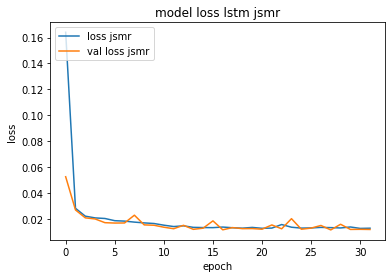

In [38]:
plt.plot(history_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_jsmr_model.history['val_loss'], label = 'val loss jsmr')
plt.title('model loss lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_jsmr', dpi=3600)

# BIDIRECTIONAL LSTM

In [191]:
def train_bidirectional_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_bidirectional_lstm = Sequential([
    Bidirectional(LSTM(neuron, activation=activation),input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_bidirectional_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_bidirectional_lstm.summary()
    history_bidirectional_lstm = model_bidirectional_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_bidirectional_lstm, history_bidirectional_lstm

#time 41.8
    

## ANTM

In [40]:
cfg_antm = [8,'relu',2,1,0.1,8,200]
model_bidirectional_antm,history_antm_model_bidirectional,  = train_bidirectional_lstm(X_train_antm,y_train_antm,cfg_antm)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 16)               640       
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
210/210 [==============================] - 6s 8ms/step - loss: 0.0349 - mae: 0.0349 - val_loss: 0.0425 - val_mae: 0.0425
Epoch 2/200
210/210 [==============================] - 1s 4ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0160 - val_mae: 0.0160
Epoch 3/200
210/210 [==============================] - 1s 4ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0442 - val

In [41]:
preds_antm_bidirectional = model_bidirectional_antm.predict(X_test_antm)
matriks_evaluate(preds_antm_bidirectional,y_test_antm,'antm')

Matriks score for antm
mae score: 0.008232755712539704
r2 score 0.9956862906506637
mape score 0.04528757310273332
rmse score 0.013190786339141062


In [31]:
# Matriks score for antm
# mae score: 0.008232755712539704
# r2 score 0.9956862906506637
# mape score 0.04528757310273332
# rmse score 0.013190786339141062

In [48]:
# Matriks score for icbp
pembulatan(0.008232755712539704
,4)
pembulatan(0.9956862906506637,4)
pembulatan(0.04528757310273332,4)
pembulatan(0.013190786339141062,4)

0.0082
0.9957
0.0453
0.0132


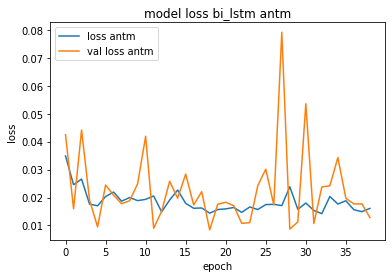

In [63]:
plt.plot(history_antm_model_bidirectional.history['loss'], label='loss antm')
plt.plot(history_antm_model_bidirectional.history['val_loss'], label = 'val loss antm')
plt.title('model loss bi_lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_antm_bidirection', dpi=3600)

## ASII

In [54]:
cfg_asii = [32,'relu',3,1,0.01,8,150]
model_bidirectional_asii,history_asii_model_bidirectional,  = train_bidirectional_lstm(X_train_asii,y_train_asii,cfg_asii)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 64)               8704      
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
209/209 [==============================] - 4s 7ms/step - loss: 0.0512 - mae: 0.0512 - val_loss: 0.0214 - val_mae: 0.0214
Epoch 2/150
209/209 [==============================] - 1s 4ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0184 - val_mae: 0.0184
Epoch 3/150
209/209 [==============================] - 1s 4ms/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0177 -

In [55]:
preds_asii_bidirectional = model_asii.predict(X_test_asii)
matriks_evaluate(preds_asii_bidirectional,y_test_asii,'asii')

Matriks score for asii
mae score: 0.014909980340267399
r2 score 0.9903039901557367
mape score 0.03413233085532062
rmse score 0.01949216813722647


In [56]:
# Matriks score for icbp
pembulatan(0.014909980340267399
,4)
pembulatan(0.9903039901557367,4)
pembulatan(0.03413233085532062,4)
pembulatan(0.01949216813722647,4)

0.0149
0.9903
0.0341
0.0195


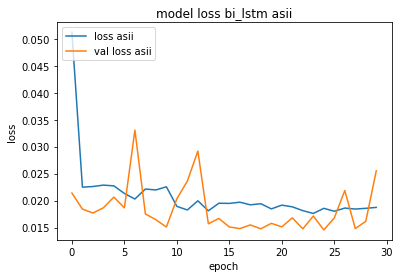

In [64]:
plt.plot(history_asii_model_bidirectional.history['loss'], label='loss asii')
plt.plot(history_asii_model_bidirectional.history['val_loss'], label = 'val loss asii')
plt.title('model loss bi_lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_asii_bidirection', dpi=3600)

## ICBP

In [57]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_icbp = [8,'relu',1,1,0.01,16,200]
model_bidirectional_icbp,history_icbp_model_bidirectional,  = train_bidirectional_lstm(X_train_icbp,y_train_icbp,cfg_icbp)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 16)               640       
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 4s 10ms/step - loss: 0.1188 - mae: 0.1188 - val_loss: 0.0184 - val_mae: 0.0184
Epoch 2/200
105/105 [==============================] - 1s 7ms/step - loss: 0.0190 - mae: 0.0190 - val_loss: 0.0144 - val_mae: 0.0144
Epoch 3/200
105/105 [==============================] - 0s 4ms/step - loss: 0.0124 - mae: 0.0124 - val_loss: 0.0088 - va

In [58]:
preds_icbp_bidirectional = model_icbp.predict(X_test_icbp)
matriks_evaluate(preds_icbp_bidirectional,y_test_icbp,'icbp')

Matriks score for icbp
mae score: 0.008158403586629956
r2 score 0.9980247438805004
mape score 0.030377509121236643
rmse score 0.012536216195277372


In [59]:
# Matriks score for icbp
pembulatan(0.008158403586629956
,4)
pembulatan(0.9980247438805004,4)
pembulatan(0.030377509121236643,4)
pembulatan(0.012536216195277372,4)

0.0082
0.998
0.0304
0.0125


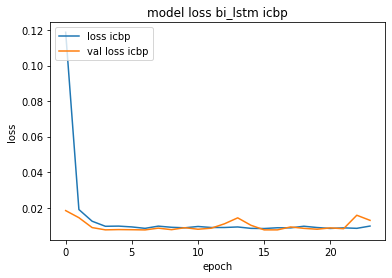

In [65]:
plt.plot(history_icbp_model_bidirectional.history['loss'], label='loss icbp')
plt.plot(history_icbp_model_bidirectional.history['val_loss'], label = 'val loss icbp')
plt.title('model loss bi_lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_icbp_bidirection', dpi=3600)

## JSMR

In [194]:
#get data and normalize data
df_jsmr = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr = reset_index_data(df_jsmr)
#data to supervised
jsmr_X, jsmr_y = split_sequence(df_jsmr, 1)
#split to train and test
X_train_jsmr, X_test_jsmr, y_train_jsmr, y_test_jsmr = train_test_split(jsmr_X, jsmr_y, test_size=0.33, random_state=42)

X_train_jsmr = reshape_data(X_train_jsmr,1)
X_test_jsmr = reshape_data(X_test_jsmr,1)


# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_jsmr = [8,'relu',1,1,0.01,16,200]
model_bidirectional_jsmr,history_jsmr_model_bidirectional,  = train_bidirectional_lstm(X_train_jsmr,y_train_jsmr,cfg_jsmr)

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_11 (Bidirecti  (None, 16)               640       
 onal)                                                           
                                                                 
 dense_35 (Dense)            (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 5s 12ms/step - loss: 0.1194 - mae: 0.1194 - val_loss: 0.0200 - val_mae: 0.0200
Epoch 2/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0223 - mae: 0.0223 - val_loss: 0.0248 - val_mae: 0.0248
Epoch 3/200
105/105 [==============================] - 0s 4ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0210 - v

In [195]:
preds_jsmr_bidirectional = model_jsmr.predict(X_test_jsmr)
matriks_evaluate(preds_jsmr_bidirectional,y_test_jsmr,'jsmr')

Matriks score for jsmr
mae score: 0.011946674405291693
r2 score 0.9937362352266612
mape score 0.036645335206422866
rmse score 0.016837957197008768


In [196]:
# Matriks score for icbp
pembulatan(0.012283945702079847
,4)
pembulatan(0.9935778068483416,4)
pembulatan(0.034951478851676564,4)
pembulatan(0.017214637390602226,4)

0.0123
0.9936
0.035
0.0172


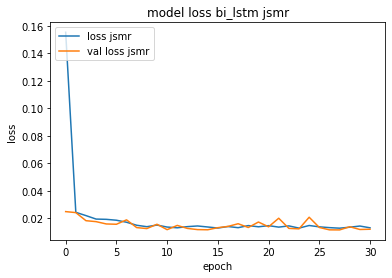

In [66]:
plt.plot(history_jsmr_model_bidirectional.history['loss'], label='loss jsmr')
plt.plot(history_jsmr_model_bidirectional.history['val_loss'], label = 'val loss jsmr')
plt.title('model loss bi_lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_jsmr_bidirection', dpi=3600)

# CNN-LSTM

In [67]:
from keras.layers import Flatten 
from keras.layers import TimeDistributed 
from keras.layers.convolutional import Conv1D 
from keras.layers.convolutional import MaxPooling1D

In [68]:
def train_cnn_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps,n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_cnn_lstm = Sequential()
    model_cnn_lstm.add(TimeDistributed(Conv1D(64,1,activation=activation), input_shape=(None,n_steps,n_features)))
    model_cnn_lstm.add(TimeDistributed(MaxPooling1D()))
    model_cnn_lstm.add(TimeDistributed(Flatten()))
    model_cnn_lstm.add(LSTM(neuron, activation=activation))
    model_cnn_lstm.add(Dense(1))
    model_cnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_cnn_lstm.summary()
    history_cnn_lstm = model_cnn_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_cnn_lstm, history_cnn_lstm

#time 41.8
    

In [69]:
def reshape_data_cnn(X,N_FEATURES, N_SEQ, N_STEPS):
    X = X.reshape(X.shape[0],N_SEQ,N_STEPS,N_FEATURES)
    return X

## ANTM

In [229]:
#get data and normalize data
df_antm_cnn = normalize_data(data_close.antm,'antm')
#reset index
df_antm_cnn = reset_index_data(df_antm_cnn)
#data to supervised
antm_X_cnn, antm_y_cnn = split_sequence(df_antm_cnn, 2)
#split to train and test
X_train_antm_cnn, X_test_antm_cnn, y_train_antm_cnn, y_test_antm_cnn = train_test_split(antm_X_cnn, antm_y_cnn, test_size=0.33, random_state=44)

X_train_antm_cnn = reshape_data_cnn(X_train_antm_cnn,1,1,2)
X_test_antm_cnn = reshape_data_cnn(X_test_antm_cnn,1,1,2)

In [230]:
cfg_antm_cnn = [8,'relu',2,1,0.1,8,200]
model_cnn_antm,history_cnn_antm_model,  = train_cnn_lstm(X_train_antm_cnn,y_train_antm_cnn,cfg_antm_cnn)

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_57 (TimeDi  (None, None, 2, 64)      128       
 stributed)                                                      
                                                                 
 time_distributed_58 (TimeDi  (None, None, 1, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_59 (TimeDi  (None, None, 64)         0         
 stributed)                                                      
                                                                 
 lstm_36 (LSTM)              (None, 8)                 2336      
                                                                 
 dense_46 (Dense)            (None, 1)                 9         
                                                     

In [231]:
preds_antm_cnn_lstm = model_cnn_antm.predict(X_test_antm_cnn)
matriks_evaluate(preds_antm_cnn_lstm,y_test_antm_cnn,'antm')

Matriks score for antm
mae score: 0.1439309050847897
r2 score -193058432560101.66
mape score 0.6079423375902168
rmse score 0.20704488253819217


In [232]:
# Matriks score for icbp
pembulatan(0.015414371122271182
,4)
pembulatan( 0.9890257070086954,4)
pembulatan(0.08284594660724198,4)
pembulatan(0.021565773748032896,4)

0.0154
0.989
0.0828
0.0216


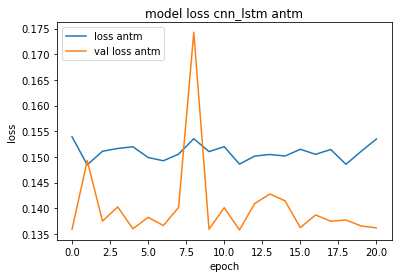

In [233]:
plt.plot(history_cnn_antm_model.history['loss'], label='loss antm')
plt.plot(history_cnn_antm_model.history['val_loss'], label = 'val loss antm')
plt.title('model loss cnn_lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_antm_cnn', dpi=3600)

## ASII

In [234]:
#get data and normalize data
df_asii_cnn = normalize_data(data_close.asii,'asii')
#reset index
df_asii_cnn = reset_index_data(df_asii_cnn)
#data to supervised
asii_X_cnn, asii_y_cnn = split_sequence(df_asii_cnn, 3)
#split to train and test
X_train_asii_cnn, X_test_asii_cnn, y_train_asii_cnn, y_test_asii_cnn = train_test_split(asii_X_cnn, asii_y_cnn, test_size=0.33, random_state=44)

X_train_asii_cnn = reshape_data_cnn(X_train_asii_cnn,1,1,3)
X_test_asii_cnn = reshape_data_cnn(X_test_asii_cnn,1,1,3)

In [235]:
cfg_asii_cnn = [32,'relu',3,1,0.1,8,150]
model_cnn_asii,history_cnn_asii_model,  = train_cnn_lstm(X_train_asii_cnn,y_train_asii_cnn,cfg_asii_cnn)

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_60 (TimeDi  (None, None, 3, 64)      128       
 stributed)                                                      
                                                                 
 time_distributed_61 (TimeDi  (None, None, 1, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_62 (TimeDi  (None, None, 64)         0         
 stributed)                                                      
                                                                 
 lstm_37 (LSTM)              (None, 32)                12416     
                                                                 
 dense_47 (Dense)            (None, 1)                 33        
                                                     

In [236]:
preds_asii_cnn_lstm = model_cnn_asii.predict(X_test_asii_cnn)
matriks_evaluate(preds_asii_cnn_lstm,y_test_asii_cnn,'asii')

Matriks score for asii
mae score: 0.02690110063972793
r2 score 0.9634259112197644
mape score 0.056128242495127975
rmse score 0.03435304247684194


In [237]:
# Matriks score for icbp
pembulatan(0.16039991534697168
,4)
pembulatan(0.0
,4)
pembulatan(0.25255010186300386,4)
pembulatan( 0.20769159327531062,4)

0.1604
0.0
0.2526
0.2077


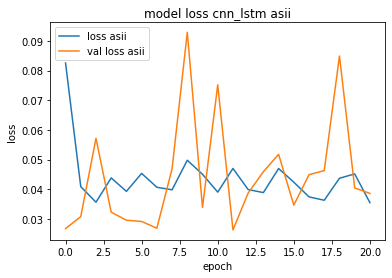

In [238]:
plt.plot(history_cnn_asii_model.history['loss'], label='loss asii')
plt.plot(history_cnn_asii_model.history['val_loss'], label = 'val loss asii')
plt.title('model loss cnn_lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_asii_cnn', dpi=3600)

## ICBP

In [239]:
#get data and normalize data
df_icbp_cnn = normalize_data(data_close.icbp,'icbp')
#reset index
df_icbp_cnn = reset_index_data(df_icbp_cnn)
#data to supervised
icbp_X_cnn, icbp_y_cnn = split_sequence(df_icbp_cnn, 2)
#split to train and test
X_train_icbp_cnn, X_test_icbp_cnn, y_train_icbp_cnn, y_test_icbp_cnn = train_test_split(icbp_X_cnn, icbp_y_cnn, test_size=0.33, random_state=44)

X_train_icbp_cnn = reshape_data_cnn(X_train_icbp_cnn,1,1,2)
X_test_icbp_cnn = reshape_data_cnn(X_test_icbp_cnn,1,1,2)

In [240]:
cfg_icbp_cnn = [8,'relu',2,1,0.1,16,200]
model_cnn_icbp,history_cnn_icbp_model,  = train_cnn_lstm(X_train_icbp_cnn,y_train_icbp_cnn,cfg_icbp_cnn)

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_63 (TimeDi  (None, None, 2, 64)      128       
 stributed)                                                      
                                                                 
 time_distributed_64 (TimeDi  (None, None, 1, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, None, 64)         0         
 stributed)                                                      
                                                                 
 lstm_38 (LSTM)              (None, 8)                 2336      
                                                                 
 dense_48 (Dense)            (None, 1)                 9         
                                                     

In [241]:
preds_icbp_cnn_lstm = model_cnn_icbp.predict(X_test_icbp_cnn)
matriks_evaluate(preds_icbp_cnn_lstm,y_test_icbp_cnn,'icbp')

Matriks score for icbp
mae score: 0.009042862018532561
r2 score 0.9975195628268448
mape score 0.04121052488118914
rmse score 0.013430368707596646


In [242]:
# Matriks score for icbp
pembulatan(0.009021557054612142
,4)
pembulatan( 0.9975961517896443
,4)
pembulatan(0.05735294469845109,4)
pembulatan(0.01385724526319,4)

0.009
0.9976
0.0574
0.0139


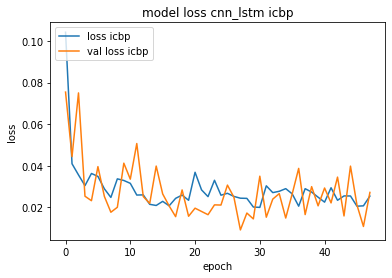

In [243]:
plt.plot(history_cnn_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_cnn_icbp_model.history['val_loss'], label = 'val loss icbp')
plt.title('model loss cnn_lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_icbp_cnn', dpi=3600)

## JSMR

In [244]:
#get data and normalize data
df_jsmr_cnn = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr_cnn = reset_index_data(df_jsmr_cnn)
#data to supervised
jsmr_X_cnn, jsmr_y_cnn = split_sequence(df_jsmr_cnn, 4)
#split to train and test
X_train_jsmr_cnn, X_test_jsmr_cnn, y_train_jsmr_cnn, y_test_jsmr_cnn = train_test_split(jsmr_X_cnn, jsmr_y_cnn, test_size=0.33, random_state=44)

X_train_jsmr_cnn = reshape_data_cnn(X_train_jsmr_cnn,1,2,2)
X_test_jsmr_cnn = reshape_data_cnn(X_test_jsmr_cnn,1,2,2)

In [245]:
cfg_jsmr_cnn = [8,'relu',2,1,0.1,16,200]
model_cnn_jsmr,history_cnn_jsmr_model,  = train_cnn_lstm(X_train_jsmr_cnn,y_train_jsmr_cnn,cfg_jsmr_cnn)

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_66 (TimeDi  (None, None, 2, 64)      128       
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, None, 1, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, None, 64)         0         
 stributed)                                                      
                                                                 
 lstm_39 (LSTM)              (None, 8)                 2336      
                                                                 
 dense_49 (Dense)            (None, 1)                 9         
                                                     

In [246]:
preds_jsmr_cnn_lstm = model_cnn_jsmr.predict(X_test_jsmr_cnn)
matriks_evaluate(preds_jsmr_cnn_lstm,y_test_jsmr_cnn,'jsmr')

Matriks score for jsmr
mae score: 0.014220918573088326
r2 score 0.9902393786187204
mape score 0.035811030992839735
rmse score 0.02039460333264722


In [247]:
# Matriks score for icbp
pembulatan(0.016145939354409146
,4)
pembulatan(0.9886551999427896
,4)
pembulatan( 0.04581825454627506,4)
pembulatan(0.02156588557280555,4)

0.0161
0.9887
0.0458
0.0216


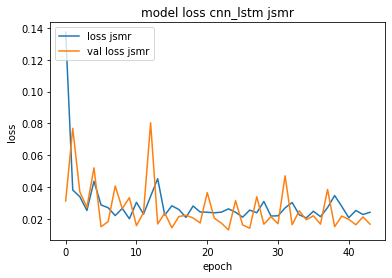

In [248]:
plt.plot(history_cnn_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_cnn_jsmr_model.history['val_loss'], label = 'val loss jsmr')
plt.title('model loss cnn_lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_jsmr_cnn', dpi=3600)

# CONVLSTM

In [249]:
def train_conv_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps,n_seq,n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_conv_lstm = Sequential()
    model_conv_lstm.add(ConvLSTM2D(neuron,(1,2),activation=activation, input_shape=(n_seq,1,n_steps,n_features)))
    model_conv_lstm.add(Flatten())
    model_conv_lstm.add(Dense(1))
    model_conv_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_conv_lstm.summary()
    history_conv_lstm = model_conv_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_conv_lstm, history_conv_lstm

#time 41.8
    

In [250]:
def reshape_data_conv(X,N_FEATURES, N_SEQ,N_ROWS, N_STEPS):
    X = X.reshape(X.shape[0],N_SEQ,N_ROWS,N_STEPS,N_FEATURES)
    return X

## ANTM

In [251]:
#get data and normalize data
df_antm_conv = normalize_data(data_close.antm,'antm')
#reset index
df_antm_conv = reset_index_data(df_antm_conv)
#data to supervised
antm_X_conv, antm_y_conv = split_sequence(df_antm_conv, 2)
#split to train and test
X_train_antm_conv, X_test_antm_conv, y_train_antm_conv, y_test_antm_conv = train_test_split(antm_X_conv, antm_y_conv, test_size=0.33, random_state=42)

X_train_antm_conv = reshape_data_conv(X_train_antm_conv,1,1,1,2)
X_test_antm_conv = reshape_data_conv(X_test_antm_conv,1,1,1,2)

In [252]:
cfg_antm_conv = [8,'relu',2,1,1,0.1,8,200]
model_conv_antm,history_conv_antm_model,  = train_conv_lstm(X_train_antm_conv,y_train_antm_conv,cfg_antm_conv)

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_10 (ConvLSTM2D)  (None, 1, 1, 8)          608       
                                                                 
 flatten_33 (Flatten)        (None, 8)                 0         
                                                                 
 dense_50 (Dense)            (None, 1)                 9         
                                                                 
Total params: 617
Trainable params: 617
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
210/210 [==============================] - 6s 5ms/step - loss: 0.0385 - mae: 0.0385 - val_loss: 0.0528 - val_mae: 0.0528
Epoch 2/200
210/210 [==============================] - 1s 4ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0718 - val_mae: 0.0718
Epoch 3/200
210/210 [==============================] 

In [253]:
preds_antm_conv_lstm = model_conv_antm.predict(X_test_antm_conv)
matriks_evaluate(preds_antm_conv_lstm,y_test_antm_conv,'antm')

Matriks score for antm
mae score: 0.013868567988121252
r2 score 0.9916294940329345
mape score 0.08660533930469173
rmse score 0.01853899017287052


In [254]:
# Matriks score for icbp
pembulatan(0.00899146769793364
,4)
pembulatan(0.9945626336182707
,4)
pembulatan( 0.04416493169252824,4)
pembulatan(0.014825447398887685,4)

0.009
0.9946
0.0442
0.0148


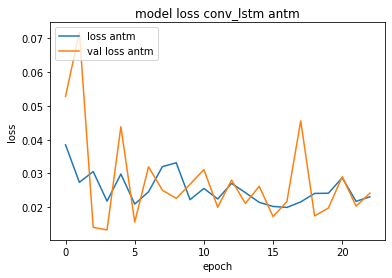

In [255]:
plt.plot(history_conv_antm_model.history['loss'], label='loss antm')
plt.plot(history_conv_antm_model.history['val_loss'], label = 'val loss antm')
plt.title('model loss conv_lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_antm_conv', dpi=3600)

## ASII

In [256]:
#get data and normalize data
df_asii_conv = normalize_data(data_close.asii,'asii')
#reset index
df_asii_conv = reset_index_data(df_asii_conv)
#data to supervised
asii_X_conv, asii_y_conv = split_sequence(df_asii_conv, 3)
#split to train and test
X_train_asii_conv, X_test_asii_conv, y_train_asii_conv, y_test_asii_conv = train_test_split(asii_X_conv, asii_y_conv, test_size=0.33, random_state=42)

X_train_asii_conv = reshape_data_conv(X_train_asii_conv,1,1,1,3)
X_test_asii_conv = reshape_data_conv(X_test_asii_conv,1,1,1,3)

In [257]:
cfg_asii_conv = [32,'relu',3,1,1,0.1,8,150]
model_conv_asii,history_conv_asii_model,  = train_conv_lstm(X_train_asii_conv,y_train_asii_conv,cfg_asii_conv)

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_11 (ConvLSTM2D)  (None, 1, 2, 32)         8576      
                                                                 
 flatten_34 (Flatten)        (None, 64)                0         
                                                                 
 dense_51 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
209/209 [==============================] - 3s 6ms/step - loss: 0.0599 - mae: 0.0599 - val_loss: 0.0951 - val_mae: 0.0951
Epoch 2/150
209/209 [==============================] - 1s 4ms/step - loss: 0.0460 - mae: 0.0460 - val_loss: 0.0240 - val_mae: 0.0240
Epoch 3/150
209/209 [============================

In [258]:
preds_asii_conv_lstm = model_conv_asii.predict(X_test_asii_conv)
matriks_evaluate(preds_asii_conv_lstm,y_test_asii_conv,'asii')

Matriks score for asii
mae score: 0.0164651276603437
r2 score 0.9860699179196417
mape score 0.04052075912256781
rmse score 0.022838300199103895


In [259]:
# Matriks score for icbp
pembulatan(0.016818273375650103
,4)
pembulatan(0.9857358941786828
,4)
pembulatan(0.04129176376671524,4)
pembulatan(0.023619429769432734,4)

0.0168
0.9857
0.0413
0.0236


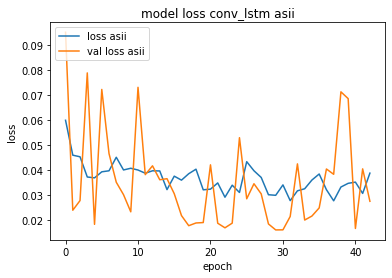

In [260]:
plt.plot(history_conv_asii_model.history['loss'], label='loss asii')
plt.plot(history_conv_asii_model.history['val_loss'], label = 'val loss asii')
plt.title('model loss conv_lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_asii_conv', dpi=3600)

## ICBP

In [261]:
#get data and normalize data
df_icbp_conv = normalize_data(data_close.icbp,'icbp')
#reset index
df_icbp_conv = reset_index_data(df_icbp_conv)
#data to supervised
icbp_X_conv, icbp_y_conv = split_sequence(df_icbp_conv, 2)
#split to train and test
X_train_icbp_conv, X_test_icbp_conv, y_train_icbp_conv, y_test_icbp_conv = train_test_split(icbp_X_conv, icbp_y_conv, test_size=0.33, random_state=42)

X_train_icbp_conv = reshape_data_conv(X_train_icbp_conv,1,1,1,2)
X_test_icbp_conv = reshape_data_conv(X_test_icbp_conv,1,1,1,2)

In [262]:
cfg_icbp_conv = [8,'relu',2,1,1,0.1,16,200]
model_conv_icbp,history_conv_icbp_model,  = train_conv_lstm(X_train_icbp_conv,y_train_icbp_conv,cfg_icbp_conv)

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_12 (ConvLSTM2D)  (None, 1, 1, 8)          608       
                                                                 
 flatten_35 (Flatten)        (None, 8)                 0         
                                                                 
 dense_52 (Dense)            (None, 1)                 9         
                                                                 
Total params: 617
Trainable params: 617
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 5s 9ms/step - loss: 0.0669 - mae: 0.0669 - val_loss: 0.0216 - val_mae: 0.0216
Epoch 2/200
105/105 [==============================] - 0s 4ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0258 - val_mae: 0.0258
Epoch 3/200
105/105 [==============================] 

In [263]:
preds_icbp_conv_lstm = model_conv_icbp.predict(X_test_icbp_conv)
matriks_evaluate(preds_icbp_conv_lstm,y_test_icbp_conv,'icbp')

Matriks score for icbp
mae score: 0.009102550450716278
r2 score 0.9975890136105561
mape score 0.0372709427074034
rmse score 0.01390575680081818


In [264]:
# Matriks score for icbp
pembulatan(0.009322962515857982
,4)
pembulatan(0.997746948456813
,4)
pembulatan(0.04788248155294555,4)
pembulatan(0.013408763512437624,4)

0.0093
0.9977
0.0479
0.0134


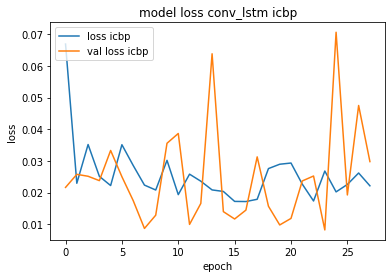

In [265]:
plt.plot(history_conv_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_conv_icbp_model.history['val_loss'], label = 'val loss icbp')
plt.title('model loss conv_lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_icbp_conv', dpi=3600)

## JSMR

In [266]:
#get data and normalize data
df_jsmr_conv = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr_conv = reset_index_data(df_jsmr_conv)
#data to supervised
jsmr_X_conv, jsmr_y_conv = split_sequence(df_jsmr_conv, 4)
#split to train and test
X_train_jsmr_conv, X_test_jsmr_conv, y_train_jsmr_conv, y_test_jsmr_conv = train_test_split(jsmr_X_conv, jsmr_y_conv, test_size=0.33, random_state=42)

X_train_jsmr_conv = reshape_data_conv(X_train_jsmr_conv,1,1,1,4)
X_test_jsmr_conv = reshape_data_conv(X_test_jsmr_conv,1,1,1,4)

In [267]:
cfg_jsmr_conv = [8,'relu',4,1,1,0.1,16,200]
model_conv_jsmr,history_conv_jsmr_model,  = train_conv_lstm(X_train_jsmr_conv,y_train_jsmr_conv,cfg_jsmr_conv)

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_13 (ConvLSTM2D)  (None, 1, 3, 8)          608       
                                                                 
 flatten_36 (Flatten)        (None, 24)                0         
                                                                 
 dense_53 (Dense)            (None, 1)                 25        
                                                                 
Total params: 633
Trainable params: 633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 4s 7ms/step - loss: 0.0577 - mae: 0.0577 - val_loss: 0.0832 - val_mae: 0.0832
Epoch 2/200
105/105 [==============================] - 0s 4ms/step - loss: 0.0465 - mae: 0.0465 - val_loss: 0.0171 - val_mae: 0.0171
Epoch 3/200
105/105 [==============================] 

In [268]:
preds_jsmr_conv_lstm = model_conv_jsmr.predict(X_test_jsmr_conv)
matriks_evaluate(preds_jsmr_conv_lstm,y_test_jsmr_conv,'jsmr')

Matriks score for jsmr
mae score: 0.012302813635162894
r2 score 0.9935203358222
mape score 0.0338080385873041
rmse score 0.016957103059135416


In [269]:
# Matriks score for icbp
pembulatan(0.012202475640973126
,4)
pembulatan(0.9938728499355909
,4)
pembulatan(0.037885215374269934,4)
pembulatan(0.016706095457821767,4)

0.0122
0.9939
0.0379
0.0167


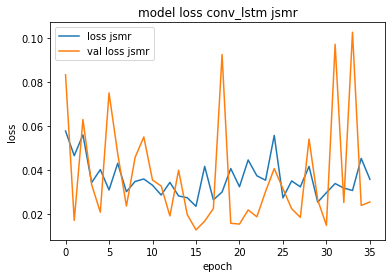

In [270]:
plt.plot(history_conv_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_conv_jsmr_model.history['val_loss'], label = 'val loss jsmr')
plt.title('model loss conv_lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_jsmr_conv', dpi=3600)

# RNN

In [ ]:
def train_rnn(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_bidirectional_lstm = Sequential([
    Bidirectional(LSTM(neuron, activation=activation),input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_bidirectional_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_bidirectional_lstm.summary()
    history_bidirectional_lstm = model_bidirectional_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_bidirectional_lstm, history_bidirectional_lstm

#time 41.8
    

# Komparasi berdasarkan Data saham

## ANTM

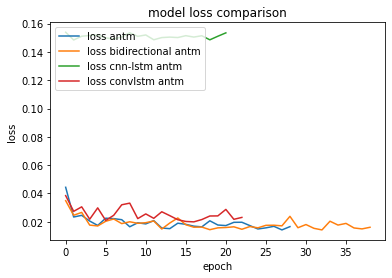

In [271]:
plt.plot(history_antm_model.history['loss'], label='loss antm')
plt.plot(history_antm_model_bidirectional.history['loss'], label='loss bidirectional antm')
plt.plot(history_cnn_antm_model.history['loss'], label='loss cnn-lstm antm')
plt.plot(history_conv_antm_model.history['loss'], label='loss convlstm antm')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm_loss_model_comparison_antm', dpi=3600)

## ASII

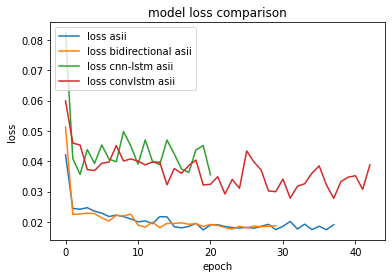

In [272]:
plt.plot(history_asii_model.history['loss'], label='loss asii')
plt.plot(history_asii_model_bidirectional.history['loss'], label='loss bidirectional asii')
plt.plot(history_cnn_asii_model.history['loss'], label='loss cnn-lstm asii')
plt.plot(history_conv_asii_model.history['loss'], label='loss convlstm asii')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm_loss_model_comparison_asii', dpi=3600)

## ICBP

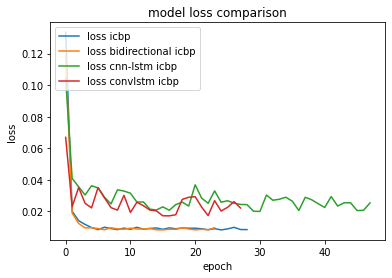

In [273]:
plt.plot(history_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_icbp_model_bidirectional.history['loss'], label='loss bidirectional icbp')
plt.plot(history_cnn_icbp_model.history['loss'], label='loss cnn-lstm icbp')
plt.plot(history_conv_icbp_model.history['loss'], label='loss convlstm icbp')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm_loss_model_comparison_icbp', dpi=3600)

## JSMR

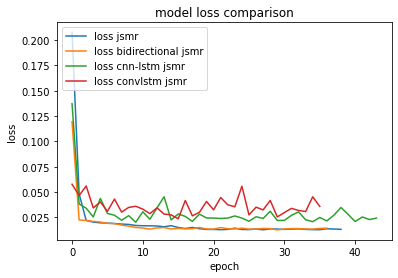

In [274]:
plt.plot(history_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_jsmr_model_bidirectional.history['loss'], label='loss bidirectional jsmr')
plt.plot(history_cnn_jsmr_model.history['loss'], label='loss cnn-lstm jsmr')
plt.plot(history_conv_jsmr_model.history['loss'], label='loss convlstm jsmr')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm_loss_model_comparison_jsmr', dpi=3600)

# KOMPARASI METRIKS EVALUASI Berdasarkan saham

## ANTM

In [275]:
mae_antm_model = {'model_lstm_antm':mean_absolute_error(preds_antm, y_test_antm),'model_bidirectional_lstm':mean_absolute_error(preds_antm_bidirectional, y_test_antm),'model_cnn_lstm':mean_absolute_error(preds_antm_cnn_lstm, y_test_antm_cnn),'model_convlstm':mean_absolute_error(preds_antm_conv_lstm, y_test_antm_conv)}

mape_antm_model = {'model_lstm_antm':mean_absolute_percentage_error(preds_antm, y_test_antm),'model_bidirectional_lstm':mean_absolute_percentage_error(preds_antm_bidirectional, y_test_antm),'model_cnn_lstm':mean_absolute_percentage_error(preds_antm_cnn_lstm, y_test_antm_cnn),'model_convlstm':mean_absolute_percentage_error(preds_antm_conv_lstm, y_test_antm)}

rmse_antm_model = {'model_lstm_antm':np.sqrt(mean_squared_error(preds_antm, y_test_antm)),'model_bidirectional_lstm':np.sqrt(mean_squared_error(preds_antm_bidirectional, y_test_antm)),'model_cnn_lstm':np.sqrt(mean_squared_error(preds_antm_cnn_lstm, y_test_antm_cnn)),'model_convlstm':np.sqrt(mean_squared_error(preds_antm_conv_lstm, y_test_antm))}

r2_antm_model = {'model_lstm_antm':r2_score(preds_antm, y_test_antm),'model_bidirectional_lstm':r2_score(preds_antm_bidirectional, y_test_antm),'model_cnn_lstm':r2_score(preds_antm_cnn_lstm, y_test_antm_cnn),'model_convlstm':r2_score(preds_antm_conv_lstm, y_test_antm)} 


In [276]:
print("sorted mae")
mae_antm_sorted = dict(sorted(mae_antm_model.items(),key=lambda item: item[1]))
print(mae_antm_sorted)
print("sorted rmse")
rmse_antm_sorted = dict(sorted(rmse_antm_model.items(),key=lambda item: item[1]))
print(rmse_antm_sorted)
print("sorted mape")
mape_antm_sorted = dict(sorted(mape_antm_model.items(),key=lambda item: item[1]))
print(mape_antm_sorted)
print("sorted r2")
r2_antm_sorted = dict(sorted(r2_antm_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_antm_sorted)

sorted mae
{'model_lstm_antm': 0.007934620954499606, 'model_bidirectional_lstm': 0.008232755712539704, 'model_convlstm': 0.013868567988121252, 'model_cnn_lstm': 0.1439309050847897}
sorted rmse
{'model_lstm_antm': 0.01301039855428923, 'model_bidirectional_lstm': 0.013190786339141062, 'model_convlstm': 0.01853899017287052, 'model_cnn_lstm': 0.20704488253819217}
sorted mape
{'model_lstm_antm': 0.04075884954250871, 'model_bidirectional_lstm': 0.04528757310273332, 'model_convlstm': 0.08660533930469173, 'model_cnn_lstm': 0.6079423375902168}
sorted r2
{'model_lstm_antm': 0.9957026171046904, 'model_bidirectional_lstm': 0.9956862906506637, 'model_convlstm': 0.9916294940329345, 'model_cnn_lstm': -193058432560101.66}


In [ ]:
# sorted mae
# {'model_lstm_antm': 0.007934620954499606, 'model_bidirectional_lstm': 0.008232755712539704, 'model_convlstm': 0.013868567988121252, 'model_cnn_lstm': 0.1439309050847897}
# sorted rmse
# {'model_lstm_antm': 0.01301039855428923, 'model_bidirectional_lstm': 0.013190786339141062, 'model_convlstm': 0.01853899017287052, 'model_cnn_lstm': 0.20704488253819217}
# sorted mape
# {'model_lstm_antm': 0.04075884954250871, 'model_bidirectional_lstm': 0.04528757310273332, 'model_convlstm': 0.08660533930469173, 'model_cnn_lstm': 0.6079423375902168}
# sorted r2
# {'model_lstm_antm': 0.9957026171046904, 'model_bidirectional_lstm': 0.9956862906506637, 'model_convlstm': 0.9916294940329345, 'model_cnn_lstm': -193058432560101.66}

## ASII

In [277]:
mae_asii_model = {'model_lstm_asii':mean_absolute_error(preds_asii, y_test_asii),'model_bidirectional_lstm':mean_absolute_error(preds_asii_bidirectional, y_test_asii),'model_cnn_lstm':mean_absolute_error(preds_asii_cnn_lstm, y_test_asii_cnn),'model_convlstm':mean_absolute_error(preds_asii_conv_lstm, y_test_asii_conv)}

mape_asii_model = {'model_lstm_asii':mean_absolute_percentage_error(preds_asii, y_test_asii),'model_bidirectional_lstm':mean_absolute_percentage_error(preds_asii_bidirectional, y_test_asii),'model_cnn_lstm':mean_absolute_percentage_error(preds_asii_cnn_lstm, y_test_asii_cnn),'model_convlstm':mean_absolute_percentage_error(preds_asii_conv_lstm, y_test_asii_conv)}

rmse_asii_model = {'model_lstm_asii':np.sqrt(mean_squared_error(preds_asii, y_test_asii)),'model_bidirectional_lstm':np.sqrt(mean_squared_error(preds_asii_bidirectional, y_test_asii)),'model_cnn_lstm':np.sqrt(mean_squared_error(preds_asii_cnn_lstm, y_test_asii_cnn)),'model_convlstm':np.sqrt(mean_squared_error(preds_asii_conv_lstm, y_test_asii_conv))}

r2_asii_model = {'model_lstm_asii':r2_score(preds_asii, y_test_asii),'model_bidirectional_lstm':r2_score(preds_asii_bidirectional, y_test_asii),'model_cnn_lstm':r2_score(preds_asii_cnn_lstm, y_test_asii_cnn),'model_convlstm':r2_score(preds_asii_conv_lstm, y_test_asii_conv)} 


In [278]:
print("sorted mae")
mae_asii_sorted = dict(sorted(mae_asii_model.items(),key=lambda item: item[1]))
print(mae_asii_sorted)
print("sorted rmse")
rmse_asii_sorted = dict(sorted(rmse_asii_model.items(),key=lambda item: item[1]))
print(rmse_asii_sorted)
print("sorted mape")
mape_asii_sorted = dict(sorted(mape_asii_model.items(),key=lambda item: item[1]))
print(mape_asii_sorted)
print("sorted r2")
r2_asii_sorted = dict(sorted(r2_asii_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_asii_sorted)

sorted mae
{'model_lstm_asii': 0.014477178205400888, 'model_bidirectional_lstm': 0.014909980340267399, 'model_convlstm': 0.0164651276603437, 'model_cnn_lstm': 0.02690110063972793}
sorted rmse
{'model_lstm_asii': 0.019196850071116774, 'model_bidirectional_lstm': 0.01949216813722647, 'model_convlstm': 0.022838300199103895, 'model_cnn_lstm': 0.03435304247684194}
sorted mape
{'model_lstm_asii': 0.03233571113583237, 'model_bidirectional_lstm': 0.03413233085532062, 'model_convlstm': 0.04052075912256781, 'model_cnn_lstm': 0.056128242495127975}
sorted r2
{'model_lstm_asii': 0.9906708116313951, 'model_bidirectional_lstm': 0.9903039901557367, 'model_convlstm': 0.9860699179196417, 'model_cnn_lstm': 0.9634259112197644}


In [ ]:
# sorted mae
# {'model_lstm_asii': 0.014477178205400888, 'model_bidirectional_lstm': 0.014909980340267399, 'model_convlstm': 0.0164651276603437, 'model_cnn_lstm': 0.02690110063972793}
# sorted rmse
# {'model_lstm_asii': 0.019196850071116774, 'model_bidirectional_lstm': 0.01949216813722647, 'model_convlstm': 0.022838300199103895, 'model_cnn_lstm': 0.03435304247684194}
# sorted mape
# {'model_lstm_asii': 0.03233571113583237, 'model_bidirectional_lstm': 0.03413233085532062, 'model_convlstm': 0.04052075912256781, 'model_cnn_lstm': 0.056128242495127975}
# sorted r2
# {'model_lstm_asii': 0.9906708116313951, 'model_bidirectional_lstm': 0.9903039901557367, 'model_convlstm': 0.9860699179196417, 'model_cnn_lstm': 0.9634259112197644}

## ICBP

In [279]:
mae_icbp_model = {'model_lstm_icbp':mean_absolute_error(preds_icbp, y_test_icbp),'model_bidirectional_lstm':mean_absolute_error(preds_icbp_bidirectional, y_test_icbp),'model_cnn_lstm':mean_absolute_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model_convlstm':mean_absolute_error(preds_icbp_conv_lstm, y_test_icbp_conv)}

mape_icbp_model = {'model_lstm_icbp':mean_absolute_percentage_error(preds_icbp, y_test_icbp),'model_bidirectional_lstm':mean_absolute_percentage_error(preds_icbp_bidirectional, y_test_icbp),'model_cnn_lstm':mean_absolute_percentage_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model_convlstm':mean_absolute_percentage_error(preds_icbp_conv_lstm, y_test_icbp_conv)}

rmse_icbp_model = {'model_lstm_icbp':np.sqrt(mean_squared_error(preds_icbp, y_test_icbp)),'model_bidirectional_lstm':np.sqrt(mean_squared_error(preds_icbp_bidirectional, y_test_icbp)),'model_cnn_lstm':np.sqrt(mean_squared_error(preds_icbp_cnn_lstm, y_test_icbp_cnn)),'model_convlstm':np.sqrt(mean_squared_error(preds_icbp_conv_lstm, y_test_icbp_conv))}

r2_icbp_model = {'model_lstm_icbp':r2_score(preds_icbp, y_test_icbp),'model_bidirectional_lstm':r2_score(preds_icbp_bidirectional, y_test_icbp),'model_cnn_lstm':r2_score(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model_convlstm':r2_score(preds_icbp_conv_lstm, y_test_icbp_conv)} 


In [280]:
print("sorted mae")
mae_icbp_sorted = dict(sorted(mae_icbp_model.items(),key=lambda item: item[1]))
print(mae_icbp_sorted)
print("sorted rmse")
rmse_icbp_sorted = dict(sorted(rmse_icbp_model.items(),key=lambda item: item[1]))
print(rmse_icbp_sorted)
print("sorted mape")
mape_icbp_sorted = dict(sorted(mape_icbp_model.items(),key=lambda item: item[1]))
print(mape_icbp_sorted)
print("sorted r2")
r2_icbp_sorted = dict(sorted(r2_icbp_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_icbp_sorted)

sorted mae
{'model_cnn_lstm': 0.009042862018532561, 'model_convlstm': 0.009102550450716278, 'model_lstm_icbp': 0.010543661521755692, 'model_bidirectional_lstm': 0.010940840614442048}
sorted rmse
{'model_cnn_lstm': 0.013430368707596646, 'model_convlstm': 0.01390575680081818, 'model_lstm_icbp': 0.017772643240530454, 'model_bidirectional_lstm': 0.01820440367217554}
sorted mape
{'model_convlstm': 0.0372709427074034, 'model_bidirectional_lstm': 0.0395334179421964, 'model_cnn_lstm': 0.04121052488118914, 'model_lstm_icbp': 0.04272024662628685}
sorted r2
{'model_convlstm': 0.9975890136105561, 'model_cnn_lstm': 0.9975195628268448, 'model_lstm_icbp': 0.9959335487091227, 'model_bidirectional_lstm': 0.9958347278374398}


In [ ]:
# sorted mae
# {'model_cnn_lstm': 0.009042862018532561, 'model_convlstm': 0.009102550450716278, 'model_lstm_icbp': 0.010543661521755692, 'model_bidirectional_lstm': 0.010940840614442048}
# sorted rmse
# {'model_cnn_lstm': 0.013430368707596646, 'model_convlstm': 0.01390575680081818, 'model_lstm_icbp': 0.017772643240530454, 'model_bidirectional_lstm': 0.01820440367217554}
# sorted mape
# {'model_convlstm': 0.0372709427074034, 'model_bidirectional_lstm': 0.0395334179421964, 'model_cnn_lstm': 0.04121052488118914, 'model_lstm_icbp': 0.04272024662628685}
# sorted r2
# {'model_convlstm': 0.9975890136105561, 'model_cnn_lstm': 0.9975195628268448, 'model_lstm_icbp': 0.9959335487091227, 'model_bidirectional_lstm': 0.9958347278374398}

## JSMR

In [281]:
print(mean_absolute_error(preds_jsmr_cnn_lstm,  y_test_jsmr_cnn))

0.014220918573088326


In [282]:
mae_jsmr_model = {'model_lstm_jsmr':mean_absolute_error(preds_jsmr, y_test_jsmr),'model_bidirectional_lstm':mean_absolute_error(preds_jsmr_bidirectional, y_test_jsmr),'model_cnn_lstm':mean_absolute_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model_convlstm':mean_absolute_error(preds_jsmr_conv_lstm, y_test_jsmr_conv)}

mape_jsmr_model = {'model_lstm_jsmr':mean_absolute_percentage_error(preds_jsmr, y_test_jsmr),'model_bidirectional_lstm':mean_absolute_percentage_error(preds_jsmr_bidirectional, y_test_jsmr),'model_cnn_lstm':mean_absolute_percentage_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model_convlstm':mean_absolute_percentage_error(preds_jsmr_conv_lstm, y_test_jsmr_conv)}

rmse_jsmr_model = {'model_lstm_jsmr':np.sqrt(mean_squared_error(preds_jsmr, y_test_jsmr)),'model_bidirectional_lstm':np.sqrt(mean_squared_error(preds_jsmr_bidirectional, y_test_jsmr)),'model_cnn_lstm':np.sqrt(mean_squared_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn)),'model_convlstm':np.sqrt(mean_squared_error(preds_jsmr_conv_lstm, y_test_jsmr_conv))}

r2_jsmr_model = {'model_lstm_jsmr':r2_score(preds_jsmr, y_test_jsmr),'model_bidirectional_lstm':r2_score(preds_jsmr_bidirectional, y_test_jsmr),'model_cnn_lstm':r2_score(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model_convlstm':r2_score(preds_jsmr_conv_lstm, y_test_jsmr_conv)} 


In [283]:
print("sorted mae")
mae_jsmr_sorted = dict(sorted(mae_jsmr_model.items(),key=lambda item: item[1]))
print(mae_jsmr_sorted)
print("sorted rmse")
rmse_jsmr_sorted = dict(sorted(rmse_jsmr_model.items(),key=lambda item: item[1]))
print(rmse_jsmr_sorted)
print("sorted mape")
mape_jsmr_sorted = dict(sorted(mape_jsmr_model.items(),key=lambda item: item[1]))
print(mape_jsmr_sorted)
print("sorted r2")
r2_jsmr_sorted = dict(sorted(r2_jsmr_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_jsmr_sorted)

sorted mae
{'model_lstm_jsmr': 0.011946674405291693, 'model_bidirectional_lstm': 0.011946674405291693, 'model_convlstm': 0.012302813635162894, 'model_cnn_lstm': 0.014220918573088326}
sorted rmse
{'model_lstm_jsmr': 0.016837957197008768, 'model_bidirectional_lstm': 0.016837957197008768, 'model_convlstm': 0.016957103059135416, 'model_cnn_lstm': 0.02039460333264722}
sorted mape
{'model_convlstm': 0.0338080385873041, 'model_cnn_lstm': 0.035811030992839735, 'model_lstm_jsmr': 0.036645335206422866, 'model_bidirectional_lstm': 0.036645335206422866}
sorted r2
{'model_lstm_jsmr': 0.9937362352266612, 'model_bidirectional_lstm': 0.9937362352266612, 'model_convlstm': 0.9935203358222, 'model_cnn_lstm': 0.9902393786187204}


In [ ]:
# sorted mae
# {'model_lstm_jsmr': 0.011946674405291693, 'model_bidirectional_lstm': 0.011946674405291693, 'model_convlstm': 0.012302813635162894, 'model_cnn_lstm': 0.014220918573088326}
# sorted rmse
# {'model_lstm_jsmr': 0.016837957197008768, 'model_bidirectional_lstm': 0.016837957197008768, 'model_convlstm': 0.016957103059135416, 'model_cnn_lstm': 0.02039460333264722}
# sorted mape
# {'model_convlstm': 0.0338080385873041, 'model_cnn_lstm': 0.035811030992839735, 'model_lstm_jsmr': 0.036645335206422866, 'model_bidirectional_lstm': 0.036645335206422866}
# sorted r2
# {'model_lstm_jsmr': 0.9937362352266612, 'model_bidirectional_lstm': 0.9937362352266612, 'model_convlstm': 0.9935203358222, 'model_cnn_lstm': 0.9902393786187204}